## Lab 6-1: Blowing snow fluxes, wind speed, and shear velocity

Written by Eli Schwat (elilouis@uw.edu) - April 2023

Modified by Eli Schwat - February 2025

---

## Library imports

In [1]:
# import libraries we'll need
import urllib
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import os
import altair as alt
alt.data_transformers.disable_max_rows()
import numpy as np
%matplotlib inline

## Open Files

Here we define a few variables to be used in the notebook. You may or may not want to change these values.

In [2]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

VARIABLES = [
    'spd_1m_ue',
    'spd_3m_ue',
    'spd_10m_ue',
    'SF_avg_1m_ue',
    'SF_avg_2m_ue'
]

The following variables are wind speed measurements at multiple heights:

> `spd_1m_ue`   - wind speed (m/s) at 1m
> 
> `spd_3m_ue`   - wind speed (m/s) at 3m
> 
> `spd_10m_ue`  - wind speed (m/s) at 10m

The following variables are blowing snow flux measurements at multiple heights:
> `SF_avg_1m_ue`   - blowing snow flux (g/m^2/s) measured between 0--1 m
> 
> `SF_avg_2m_ue`   - blowing snow flux (g/m^2/s) measured between 1--2 m

We also use a 30-minute precipitation dataset for this lab. This data is from a "laser disdrometer". 

In [3]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [4]:
precip_df = pd.read_csv("../data/kettle_ponds_precip_30min.csv")
precip_df['time'] = pd.to_datetime(precip_df['time'])
precip_df.head()

,time,precip_rate
0,2022-11-01 00:00:00,0.0
1,2022-11-01 00:30:00,0.0
2,2022-11-01 01:00:00,0.0
3,2022-11-01 01:30:00,0.0
4,2022-11-01 02:00:00,0.0


We will also use a lidar dataset for this lab. A lidar box was deployed at Kettle Ponds, mounted at 10 meters, pointing down to the ground. When there is blowing snow, the lidar scanning laser will bounce off snowflakes suspended in the air. 

The lidar data, opened up below, has been preprocessed for us by Ethan Gutmann at NCAR.
In simple terms, the dataset contains a snow particule count of snow moving near the lidar sensor (mounted 10m above the ground).
In complex terms, the dataset contains a count of "lidar returns" (for those who know about lidar, this lidar device only records *first* created by Ethan Gutmann at NCAR) within a 1 meter distance that the lidar recorded over a 10 second period at the top of the hour.  This is the lidar mounted on the upper east tower, the same tower that has the FlowCapt sensors on it. Because the lidar is mounted at 10 m height on the tower, this gives us an hourly 10-second particle count at an elevation 9-10 meters off the bare ground.  Note that the dataset includes returns from snowflakes during times when it is snowing in addition to blowing snow.

Below, we investigate how the lidar observations of of blowing snow compare with the FlowCapt sensors, which are built specifically to measure blowing snow.

In [5]:
lidar_file = "../data/lidar_l2_particles.nc"
lidar_dataset = xr.open_dataset(lidar_file)

## Plot wind speed and blowing snow flux time series

Here we look at wind speed and  blowing snow fluxes over the season, until April 7, when melt started. After April 7, blowing snow is unlikely because the snow is wet/heavy.

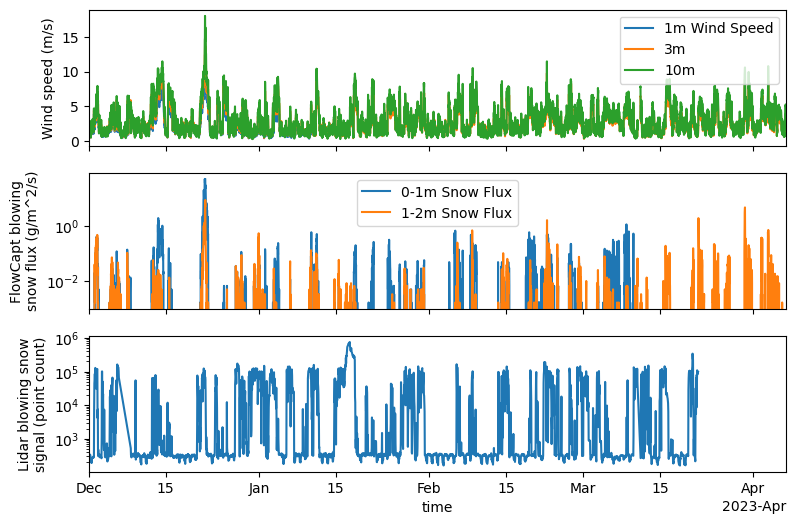

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(9,6), sharex=True)
sos_dataset['spd_1m_ue'].plot(ax=axes[0], label='1m Wind Speed')
sos_dataset['spd_3m_ue'].plot(ax=axes[0], label='3m')
sos_dataset['spd_10m_ue'].plot(ax=axes[0], label='10m')
sos_dataset['SF_avg_1m_ue'].plot(ax=axes[1], label='0-1m Snow Flux')
sos_dataset['SF_avg_2m_ue'].plot(ax=axes[1], label='1-2m Snow Flux')
lidar_dataset['suspended_points'].plot(ax=axes[2], label='lidar snow flux')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[1].set_yscale("log")
axes[2].set_yscale("log")
axes[0].set_xlim(dt.datetime(2022,12,1), dt.datetime(2023,4,7))
axes[0].set_ylabel("Wind speed (m/s)")
axes[1].set_ylabel("FlowCapt blowing\nsnow flux (g/m^2/s)")
axes[2].set_ylabel("Lidar blowing snow\nsignal (point count)")
plt.show()

We see that generally, wind speed and blowing snow flux are correlated. Also note that generally, the 0-1m instrument measures more blowing snow than the 1-2m instrument. 
Later in the season, we see that 1--2 meter fluxes become more common, this is because the snow is deep enough that the 0--1m instrument was buried.

We also can see that the lidar instrument does a pretty decent job recreating the blowing snow flux signal, however there are definitely some times when when the LIDAR says there is blowing snow but the FlowCapt sensors say there is not (probably during snowfall?)

## Identifying wind speed and u* thresholds for blowing snow transport

Let's calculate a total blowing snow flux from the two instruments so that we can analyze blowing snow flux independently of the instrument height

In [7]:
sos_dataset['SF_avg_ue'] = sos_dataset['SF_avg_1m_ue'] + sos_dataset['SF_avg_2m_ue']

Now let's see if we can identify a wind speed threshold for blowing snow. Let's also see if there is a u* (shear velocity) threshold for blowing snow.

We will use measurements at 3 meters.

In [8]:
sos_df = sos_dataset.to_dataframe()

In [9]:
bsflux_vs_spd = alt.Chart(
    sos_df[['spd_3m_c', 'SF_avg_ue']]
).mark_circle().encode(
    alt.X('spd_3m_c'),
    alt.Y('SF_avg_ue')
)

bsflux_vs_ustar = alt.Chart(
    sos_df[['u*_3m_c', 'SF_avg_ue']]
).mark_circle().encode(
    alt.X('u*_3m_c'),
    alt.Y('SF_avg_ue')
)

bsflux_vs_spd | bsflux_vs_ustar

alt.HConcatChart(...)

BS flux appears logarithmically distributed...let's make the blowing snow axis log-scale and remove data points with zero blowing snow

In [10]:
bsflux_vs_spd = alt.Chart(
    sos_df[['spd_3m_c', 'SF_avg_ue']].query("SF_avg_ue > 0")
).mark_circle().encode(
    alt.X('spd_3m_c'),
    alt.Y('SF_avg_ue').scale(type='log')
)

bsflux_vs_ustar = alt.Chart(
    sos_df[['u*_3m_c', 'SF_avg_ue']].query("SF_avg_ue > 0")
).mark_circle().encode(
    alt.X('u*_3m_c'),
    alt.Y('SF_avg_ue').scale(type='log')
)

bsflux_vs_spd | bsflux_vs_ustar

alt.HConcatChart(...)

So there is a lot of blowing snow fluxes that are less than 1 g/m^2/s.

Considering only blowing snow fluxes > 1 g/m^2/s, a wind speed threshold of 4 m/s appears to work for blowing snow fluxes greater than 0.1 g/m^2/s. 
A wind speed threshold of 8 m/s seems to work for large blowing snow fluxes, greater than 1 or 2 g/m^2/s

For shear velocity, a threshold of 0.2 seems to work for blowing snow fluxes greater than 0.1 g/m^2/s. 

In [11]:
(
    (bsflux_vs_spd + alt.Chart().transform_calculate(x='4').mark_rule(color='red').encode(x='x:Q'))
    | 
    (bsflux_vs_ustar + alt.Chart().transform_calculate(x='0.2').mark_rule(color='red').encode(x='x:Q'))
)

alt.HConcatChart(...)

## Incorporating snow "freshness"

Using our precip dataset, let's calculate an "hours since new precipitation" variable.

Then, we will bin each data point by this variable, and see how that affects the above. We hypothesize that most of the small blowing snow fluxes during small winds are occurring immediately after (or during) precipitation.

In [12]:
precip_df.head(4)

,time,precip_rate
0,2022-11-01 00:00:00,0.0
1,2022-11-01 00:30:00,0.0
2,2022-11-01 01:00:00,0.0
3,2022-11-01 01:30:00,0.0


In [13]:
s = precip_df.groupby(precip_df['precip_rate'].ne(0).cumsum())['time'].transform('first')
seconds_in_an_hour = 3600
precip_df['hours_since_precip'] = (precip_df['time'] - s).dt.total_seconds() / seconds_in_an_hour

In [14]:
bs_df = sos_df[['spd_3m_c', 'SF_avg_ue', 'RH_3m_c']].join(precip_df.set_index('time'))
bs_df.head()

,spd_3m_c,SF_avg_ue,RH_3m_c,precip_rate,hours_since_precip
time,,,,,
2022-11-01 00:00:00,0.846023,0.0,71.365135,0.0,0.0
2022-11-01 00:30:00,2.358271,0.0,70.626610,0.0,0.5
2022-11-01 01:00:00,1.582793,0.0,76.214073,0.0,1.0
2022-11-01 01:30:00,2.225387,0.0,76.811729,0.0,1.5
2022-11-01 02:00:00,2.548928,0.0,77.684540,0.0,2.0


In [15]:
alt.Chart(
    bs_df.loc['20221130': '20230509'].query("SF_avg_ue > 0").query("hours_since_precip > 0")
).mark_circle().encode(
    alt.X('spd_3m_c'),
    alt.Y('SF_avg_ue').scale(type='log'),
    alt.Color('hours_since_precip:O').bin(step=12).scale(scheme='turbo'),
    alt.Size('hours_since_precip:O').bin(step=12)
).properties(width=300, height=300)

alt.Chart(...)

So actually, there are still very small (< 0.01 g/m^2/s) blowing snow fluxes that occur 24 hours after blowing snow.
But above 0.01 g/m^2/s, it does look like that blowing snow fluxes 24 hours after precipitation, are not likely to occur below 4 m/s.

## Incorporating relative humidity

Let's try a similar plot to the above, but bin by relative humidity.

In [16]:
alt.Chart(
    bs_df.loc['20221130': '20230509'].query("SF_avg_ue > 0").query("hours_since_precip > 0")
).mark_circle().encode(
    alt.X('spd_3m_c'),
    alt.Y('SF_avg_ue').scale(type='log'),
    alt.Color('RH_3m_c:O').bin(step=5).scale(scheme='turbo'),
    # alt.Size('RH_3m_c:O').bin(step=5)
).properties(width=300, height=300)

alt.Chart(...)

This seems to separate out data quite nicely - in super dry conditions, blowing snow occurs at very low wind speeds.

During humid conditions, blowing snow only happens at wind speeds > 5 m/s.

This signal seems to break down at 0.01 g/m^2/s. 
To me, this suggests that measured blowing snow fluxes below 0.01 g/m^2/s cannot necessarily be trusted. 
Trouvilliez et al., 2015 have lots to say on the reliability of the FlowCapt sensors (https://journals.ametsoc.org/view/journals/atot/32/9/jtech-d-14-00104_1.xml).